##### Импорт библиотек

In [169]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 
import xgboost as xgb
from lightgbm import LGBMRegressor
import joblib

import warnings
from lightgbm import LGBMRegressor

import os
os.makedirs('models', exist_ok=True)

# Отключаем логи LightGBM
import logging
logging.getLogger('lightgbm').setLevel(logging.WARNING)

print("Библиотеки загружены!\n")

df = pd.read_csv('df/obr.csv', parse_dates=['datetime'], index_col='datetime')
print(f"Данные загружены: {df.shape}")

Библиотеки загружены!

Данные загружены: (260640, 11)


In [170]:
# УЛУЧШЕННОЕ СОЗДАНИЕ ПРИЗНАКОВ
print("Создание УЛУЧШЕННЫХ признаков на основе EDA...")
print(f"Исходный размер: {df.shape}")

# ===== ОСНОВНЫЕ ПРИЗНАКИ (у тебя уже есть) =====
# Циклические признаки
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)

# Пиковые периоды  
df['is_evening_peak'] = ((df['hour'] >= 18) & (df['hour'] <= 22)).astype(int)
df['is_morning_peak'] = ((df['hour'] >= 7) & (df['hour'] <= 9)).astype(int)
df['is_night'] = ((df['hour'] >= 0) & (df['hour'] <= 6)).astype(int)

# Особые дни
df['is_sunday'] = (df['day_of_week'] == 6).astype(int)
df['is_friday'] = (df['day_of_week'] == 4).astype(int)

# ===== УЛУЧШЕННЫЕ ПРИЗНАКИ (НОВЫЕ) =====
# 1. Более детальные пиковые периоды
df['is_afternoon'] = ((df['hour'] >= 12) & (df['hour'] <= 17)).astype(int)
df['is_late_night'] = ((df['hour'] >= 23) | (df['hour'] <= 3)).astype(int)

# 2. Комбинированные временные признаки
df['hour_type'] = df['hour'].apply(lambda x: 
    'night' if x <= 6 else 
    'morning_peak' if 7 <= x <= 9 else
    'day' if 10 <= x <= 17 else
    'evening_peak' if 18 <= x <= 22 else
    'late_night'
)

# 3. Расширенные лаги (из анализа автокорреляции)
df['lag_1h'] = df['Global_active_power'].shift(1)    # 1 час назад
df['lag_2h'] = df['Global_active_power'].shift(2)    # 2 часа назад  
df['lag_3h'] = df['Global_active_power'].shift(3)    # 3 часа назад
df['lag_6h'] = df['Global_active_power'].shift(6)    # 6 часов назад
df['lag_12h'] = df['Global_active_power'].shift(12)  # 12 часов назад
df['lag_24h'] = df['Global_active_power'].shift(24)  # 24 часа назад

# 4. Расширенные скользящие статистики
df['rolling_mean_1h'] = df['Global_active_power'].rolling(window=1).mean()    # Текущее значение
df['rolling_mean_3h'] = df['Global_active_power'].rolling(window=3).mean()    # 3 часа
df['rolling_mean_6h'] = df['Global_active_power'].rolling(window=6).mean()    # 6 часов
df['rolling_mean_12h'] = df['Global_active_power'].rolling(window=12).mean()  # 12 часов
df['rolling_mean_24h'] = df['Global_active_power'].rolling(window=24).mean()  # 24 часа

# 5. Волатильность и тренды
df['rolling_std_3h'] = df['Global_active_power'].rolling(window=3).std()      # Волатильность 3ч
df['rolling_std_24h'] = df['Global_active_power'].rolling(window=24).std()    # Волатильность 24ч
df['hourly_trend'] = df['rolling_mean_3h'] - df['rolling_mean_24h']           # Краткосрочный тренд

# 6. Взаимодействие признаков
df['weekend_evening'] = (df['is_weekend'] & df['is_evening_peak']).astype(int)
df['workday_morning'] = ((~df['is_weekend']) & df['is_morning_peak']).astype(int)

# 7. Сезонные особенности (зима/лето)
df['is_winter'] = df['month'].isin([1, 2, 12]).astype(int)  # Зимние месяцы
df['is_summer'] = df['month'].isin([6, 7, 8]).astype(int)   # Летние месяцы

# ===== ОБРАБОТКА ПРОПУСКОВ (ИСПРАВЛЕННАЯ ВЕРСИЯ) =====
print("Обработка пропусков...")
initial_size = len(df)

# Заполняем пропуски в числовых признаках
numeric_columns = df.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    if df[col].isnull().any():
        # Для лагов и скользящих - заполняем предыдущими значениями (ИСПРАВЛЕННЫЙ СПОСОБ)
        if 'lag' in col or 'rolling' in col:
            df[col] = df[col].ffill().bfill()  # Вместо fillna(method='...')
        else:
            df[col] = df[col].fillna(df[col].median())

# Категориальные признаки
if 'hour_type' in df.columns:
    df['hour_type'] = df['hour_type'].fillna('unknown')

# Удаляем оставшиеся пропуски (если есть)
df = df.dropna()

print(f"Признаки созданы. Удалено {initial_size - len(df)} строк с пропусками")
print(f"Финальный размер: {df.shape}")
print(f"Колонки ({len(df.columns)}): {list(df.columns)}")

Создание УЛУЧШЕННЫХ признаков на основе EDA...
Исходный размер: (260640, 11)
Обработка пропусков...
Признаки созданы. Удалено 0 строк с пропусками
Финальный размер: (260640, 39)
Колонки (39): ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'hour', 'day_of_week', 'month', 'is_weekend', 'hour_sin', 'hour_cos', 'is_evening_peak', 'is_morning_peak', 'is_night', 'is_sunday', 'is_friday', 'is_afternoon', 'is_late_night', 'hour_type', 'lag_1h', 'lag_2h', 'lag_3h', 'lag_6h', 'lag_12h', 'lag_24h', 'rolling_mean_1h', 'rolling_mean_3h', 'rolling_mean_6h', 'rolling_mean_12h', 'rolling_mean_24h', 'rolling_std_3h', 'rolling_std_24h', 'hourly_trend', 'weekend_evening', 'workday_morning', 'is_winter', 'is_summer']


In [171]:
df.sample(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,day_of_week,month,...,rolling_mean_6h,rolling_mean_12h,rolling_mean_24h,rolling_std_3h,rolling_std_24h,hourly_trend,weekend_evening,workday_morning,is_winter,is_summer
datetime,,,,,,,,,,,,,,,,,,,,,
2007-01-11 05:01:00,0.400,0.294,243.39,2.0,0.0,1.0,0.0,5,3,1,...,0.400333,0.318167,0.296500,0.002309,0.068177,0.104833,0,0,1,0
2007-03-06 18:27:00,0.670,0.194,237.71,2.8,0.0,2.0,0.0,18,1,3,...,0.671333,0.704333,0.717833,0.002309,0.080230,-0.049167,0,0,0,0
2007-05-25 02:46:00,1.312,0.050,236.01,5.4,0.0,2.0,17.0,2,4,5,...,1.402333,1.422833,1.029250,0.048497,0.542264,0.334750,0,0,0,0
2007-04-24 09:38:00,0.348,0.090,234.59,1.6,0.0,0.0,0.0,9,1,4,...,0.338000,0.278500,0.236750,0.008718,0.062720,0.101250,0,1,0,0
2007-02-03 03:07:00,2.292,0.000,239.68,9.4,0.0,0.0,0.0,3,5,2,...,2.299000,2.578500,2.983417,0.004163,0.527167,-0.686750,0,0,1,0


In [172]:
# ПОДГОТОВКА ДАННЫХ ДЛЯ ОБУЧЕНИЯ
print("Подготовка данных...")

# Целевая переменная
y = df['Global_active_power']

# Признаки (исключаем целевую, временную метку, утекающие параметры и СТРОКОВЫЕ признаки)
feature_columns = [col for col in df.columns if col not in [
    'Global_active_power',  # целевая переменная
    'Global_intensity',     # УТЕЧКА 
    'Global_reactive_power', # УТЕЧКА
    'Voltage',              # УТЕЧКА
    'datetime',             # временная метка
    'hour_type'             # СТРОКОВЫЙ ПРИЗНАК - удаляем!
] and df[col].dtype != 'object']  # ← ВАЖНО: исключаем ВСЕ строковые признаки

print(f"Используем {len(feature_columns)} признаков (без утекающих):")
print(feature_columns)

X = df[feature_columns]

print(f"Признаки: {len(feature_columns)}")
print(f"Целевая переменная: {y.name}")
print(f"Типы признаков:")
print(X.dtypes.value_counts())

# Разделение на train/test с учетом времени (ВАЖНО для временных рядов!)
# Берем первые 80% для обучения, последние 20% для тестирования
split_index = int(len(df) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]

y_train = y.iloc[:split_index] 
y_test = y.iloc[split_index:]

print(f"\nРазделение данных:")
print(f"Обучающая выборка: {X_train.shape[0]} записей")
print(f"Тестовая выборка: {X_test.shape[0]} записей")
print(f"Дата начала train: {X_train.index.min()}")
print(f"Дата конца test: {X_test.index.max()}")

Подготовка данных...
Используем 34 признаков (без утекающих):
['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'hour', 'day_of_week', 'month', 'is_weekend', 'hour_sin', 'hour_cos', 'is_evening_peak', 'is_morning_peak', 'is_night', 'is_sunday', 'is_friday', 'is_afternoon', 'is_late_night', 'lag_1h', 'lag_2h', 'lag_3h', 'lag_6h', 'lag_12h', 'lag_24h', 'rolling_mean_1h', 'rolling_mean_3h', 'rolling_mean_6h', 'rolling_mean_12h', 'rolling_mean_24h', 'rolling_std_3h', 'rolling_std_24h', 'hourly_trend', 'weekend_evening', 'workday_morning', 'is_winter', 'is_summer']
Признаки: 34
Целевая переменная: Global_active_power
Типы признаков:
float64    19
int64      15
Name: count, dtype: int64

Разделение данных:
Обучающая выборка: 208512 записей
Тестовая выборка: 52128 записей
Дата начала train: 2007-01-01 00:00:00
Дата конца test: 2007-06-30 23:59:00


In [173]:
# ОБУЧЕНИЕ МОДЕЛЕЙ
print("Обучение моделей...")

# Словарь для хранения моделей и результатов
models = {}
results = {}

# A. RANDOM FOREST
print("\nОбучение RandomForest...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
models['RandomForest'] = rf_model

# B. XGBOOST
print("Обучение XGBoost...")
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)
models['XGBoost'] = xgb_model

# C. LIGHTGBM
print("Обучение LightGBM...")
lgb_model = LGBMRegressor(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgb_model.fit(X_train, y_train)
models['LightGBM'] = lgb_model

print("Все модели обучены!")

Обучение моделей...

Обучение RandomForest...
Обучение XGBoost...
Обучение LightGBM...
Все модели обучены!



Оценка качества моделей на тестовой выборке:

RandomForest:
  MAE:  0.0002 кВт
  RMSE: 0.0015 кВт
  R²:   1.0000

XGBoost:
  MAE:  0.0047 кВт
  RMSE: 0.0159 кВт
  R²:   0.9997

LightGBM:
  MAE:  0.0045 кВт
  RMSE: 0.0135 кВт
  R²:   0.9998

СРАВНЕНИЕ МОДЕЛЕЙ:
Лучшая модель по MAE: RandomForest

Визуализация результатов...


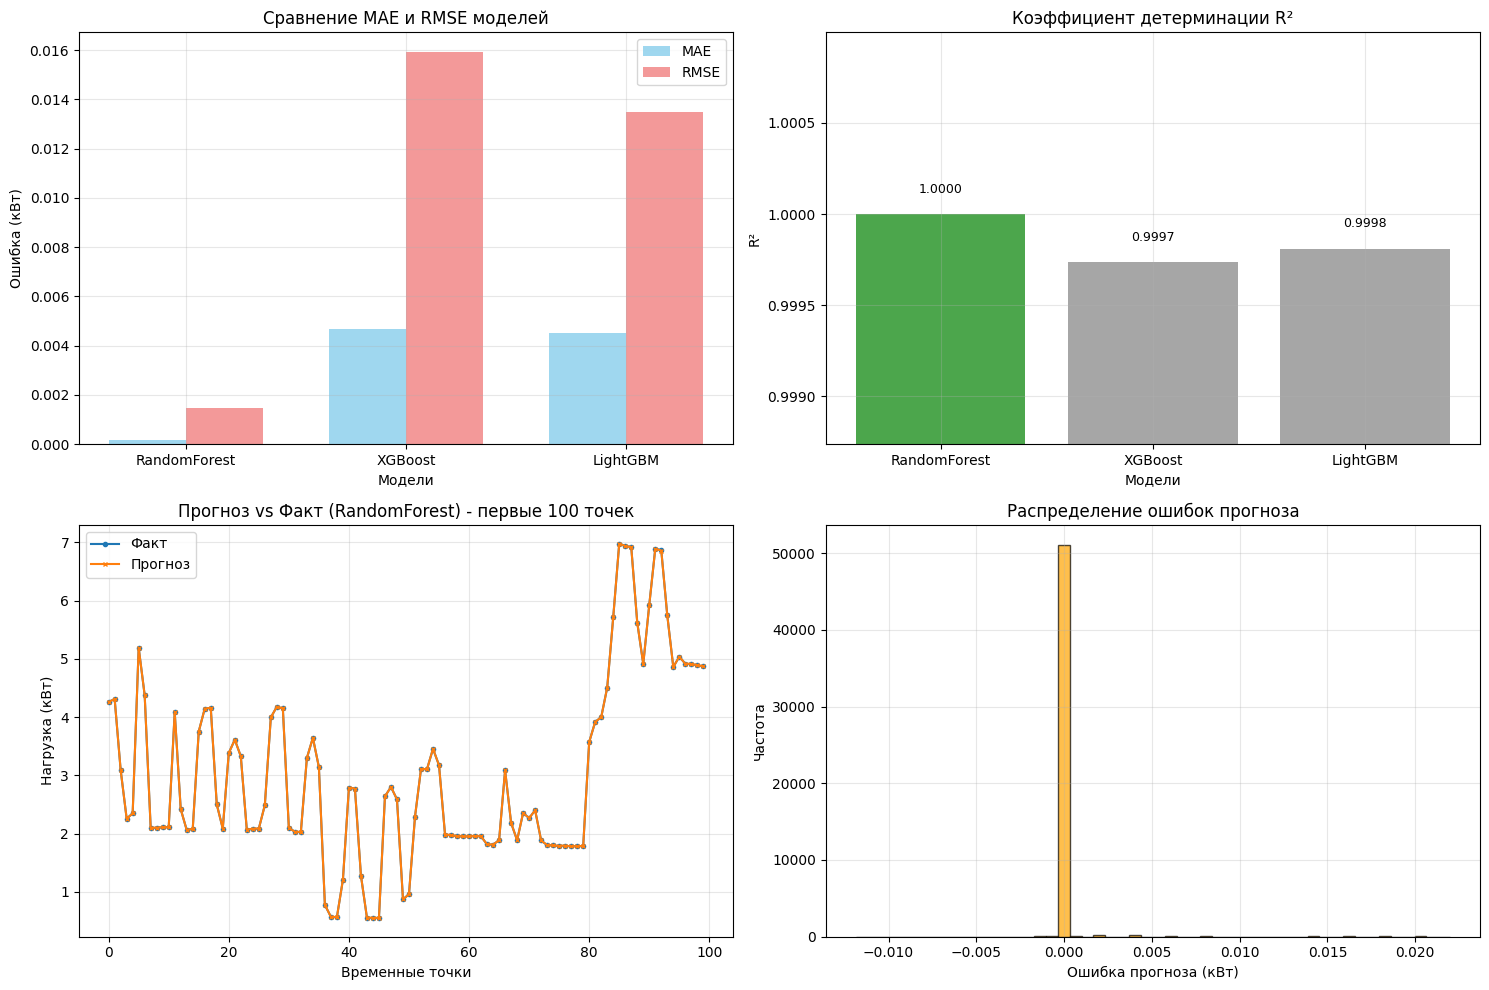


ТАБЛИЦА МЕТРИК:
Модель          MAE (кВт)    RMSE (кВт)   R²        
RandomForest    0.0002       0.0015       1.0000     
XGBoost         0.0047       0.0159       0.9997    
LightGBM        0.0045       0.0135       0.9998    

АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ (RandomForest):
• Средняя ошибка: 0.2 Вт
• Точность прогноза: 100.00%
• Максимальная ошибка: 22.0 Вт


In [174]:
# ОЦЕНКА КАЧЕСТВА МОДЕЛЕЙ
print("\nОценка качества моделей на тестовой выборке:")

for name, model in models.items():
    # Прогнозы
    y_pred = model.predict(X_test)
    
    # Метрики
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MAE': mae,
        'RMSE': rmse, 
        'R2': r2,
        'predictions': y_pred
    }
    
    print(f"\n{name}:")
    print(f"  MAE:  {mae:.4f} кВт")
    print(f"  RMSE: {rmse:.4f} кВт") 
    print(f"  R²:   {r2:.4f}")

# Сравнение моделей
print("\nСРАВНЕНИЕ МОДЕЛЕЙ:")
best_model = min(results, key=lambda x: results[x]['MAE'])
print(f"Лучшая модель по MAE: {best_model}")

# ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ
print("\nВизуализация результатов...")
import matplotlib.pyplot as plt

# ГРАФИК СРАВНЕНИЯ МЕТРИК
plt.figure(figsize=(15, 10))

# График 1: Сравнение метрик
plt.subplot(2, 2, 1)
metrics = ['MAE', 'RMSE']
models_names = list(results.keys())
mae_values = [results[model]['MAE'] for model in models_names]
rmse_values = [results[model]['RMSE'] for model in models_names]

x = np.arange(len(models_names))
width = 0.35

plt.bar(x - width/2, mae_values, width, label='MAE', alpha=0.8, color='skyblue')
plt.bar(x + width/2, rmse_values, width, label='RMSE', alpha=0.8, color='lightcoral')

plt.xlabel('Модели')
plt.ylabel('Ошибка (кВт)')
plt.title('Сравнение MAE и RMSE моделей')
plt.xticks(x, models_names)
plt.legend()
plt.grid(True, alpha=0.3)

# График 2: R² сравнение (ИСПРАВЛЕННЫЙ)
plt.subplot(2, 2, 2)
r2_values = [results[model]['R2'] for model in models_names]
colors = ['green' if model == best_model else 'gray' for model in models_names]

# Автоматически подбираем масштаб
r2_min, r2_max = min(r2_values), max(r2_values)
plt.ylim(r2_min - 0.001, r2_max + 0.001)  # Динамический масштаб

plt.bar(models_names, r2_values, color=colors, alpha=0.7)
plt.xlabel('Модели')
plt.ylabel('R²')
plt.title('Коэффициент детерминации R²')
plt.grid(True, alpha=0.3)

# Добавляем значения на столбцы
for i, v in enumerate(r2_values):
    plt.text(i, v + 0.0001, f'{v:.4f}', ha='center', va='bottom', fontsize=9)

# График 3: Прогнозы vs Факт (для лучшей модели)
plt.subplot(2, 2, 3)
best_predictions = results[best_model]['predictions']

# Берем первые 100 точек для наглядности
sample_size = min(100, len(y_test))
plt.plot(y_test.values[:sample_size], label='Факт', marker='o', markersize=3)
plt.plot(best_predictions[:sample_size], label='Прогноз', marker='x', markersize=3)
plt.xlabel('Временные точки')
plt.ylabel('Нагрузка (кВт)')
plt.title(f'Прогноз vs Факт ({best_model}) - первые 100 точек')
plt.legend()
plt.grid(True, alpha=0.3)

# График 4: Ошибки прогноза
plt.subplot(2, 2, 4)
errors = best_predictions - y_test.values
plt.hist(errors, bins=50, alpha=0.7, color='orange', edgecolor='black')
plt.xlabel('Ошибка прогноза (кВт)')
plt.ylabel('Частота')
plt.title('Распределение ошибок прогноза')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ТАБЛИЦА С МЕТРИКАМИ
print("\nТАБЛИЦА МЕТРИК:")
print("="*50)
print(f"{'Модель':<15} {'MAE (кВт)':<12} {'RMSE (кВт)':<12} {'R²':<10}")
print("="*50)
for model in models_names:
    mae = results[model]['MAE']
    rmse = results[model]['RMSE']
    r2 = results[model]['R2']
    marker = " " if model == best_model else ""
    print(f"{model:<15} {mae:<12.4f} {rmse:<12.4f} {r2:<10.4f}{marker}")
print("="*50)

# АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ
print(f"\nАНАЛИЗ ЛУЧШЕЙ МОДЕЛИ ({best_model}):")
best_mae = results[best_model]['MAE']
best_rmse = results[best_model]['RMSE']
best_r2 = results[best_model]['R2']

print(f"• Средняя ошибка: {best_mae*1000:.1f} Вт")
print(f"• Точность прогноза: {best_r2*100:.2f}%")
print(f"• Максимальная ошибка: {np.max(np.abs(best_predictions - y_test.values))*1000:.1f} Вт")

In [175]:
# СОХРАНЕНИЕ МОДЕЛЕЙ И РЕЗУЛЬТАТОВ
print("Сохранение результатов...")

# Сохраняем все модели
for name, model in models.items():
    filename = f'models/{name.lower()}_model.pkl'
    joblib.dump(model, filename)
    print(f"{name} сохранен в {filename}")

# Сохраняем метрики в CSV
results_df = pd.DataFrame(results).T
results_df.to_csv('models/model_metrics.csv')
print("Метрики моделей сохранены")

print(f"\nВСЁ ЗАВЕРШЕНО! Лучшая модель: {best_model} (MAE: {results[f'{best_model}']['MAE']:.4f} кВт)")

Сохранение результатов...
RandomForest сохранен в models/randomforest_model.pkl
XGBoost сохранен в models/xgboost_model.pkl
LightGBM сохранен в models/lightgbm_model.pkl
Метрики моделей сохранены

ВСЁ ЗАВЕРШЕНО! Лучшая модель: RandomForest (MAE: 0.0002 кВт)


ИНТЕРПРЕТАЦИЯ МОДЕЛЕЙ - АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ

ТОП-15 самых важных признаков по версии XGBoost:
 1. rolling_mean_1h           0.9956 (99.56%)
 2. is_afternoon              0.0008 (0.08%)
 3. hourly_trend              0.0006 (0.06%)
 4. Sub_metering_2            0.0003 (0.03%)
 5. rolling_mean_6h           0.0003 (0.03%)
 6. rolling_mean_24h          0.0003 (0.03%)
 7. Sub_metering_1            0.0002 (0.02%)
 8. Sub_metering_3            0.0002 (0.02%)
 9. rolling_std_3h            0.0002 (0.02%)
10. day_of_week               0.0002 (0.02%)
11. lag_24h                   0.0001 (0.01%)
12. rolling_mean_3h           0.0001 (0.01%)
13. lag_2h                    0.0001 (0.01%)
14. month                     0.0001 (0.01%)
15. hour                      0.0001 (0.01%)


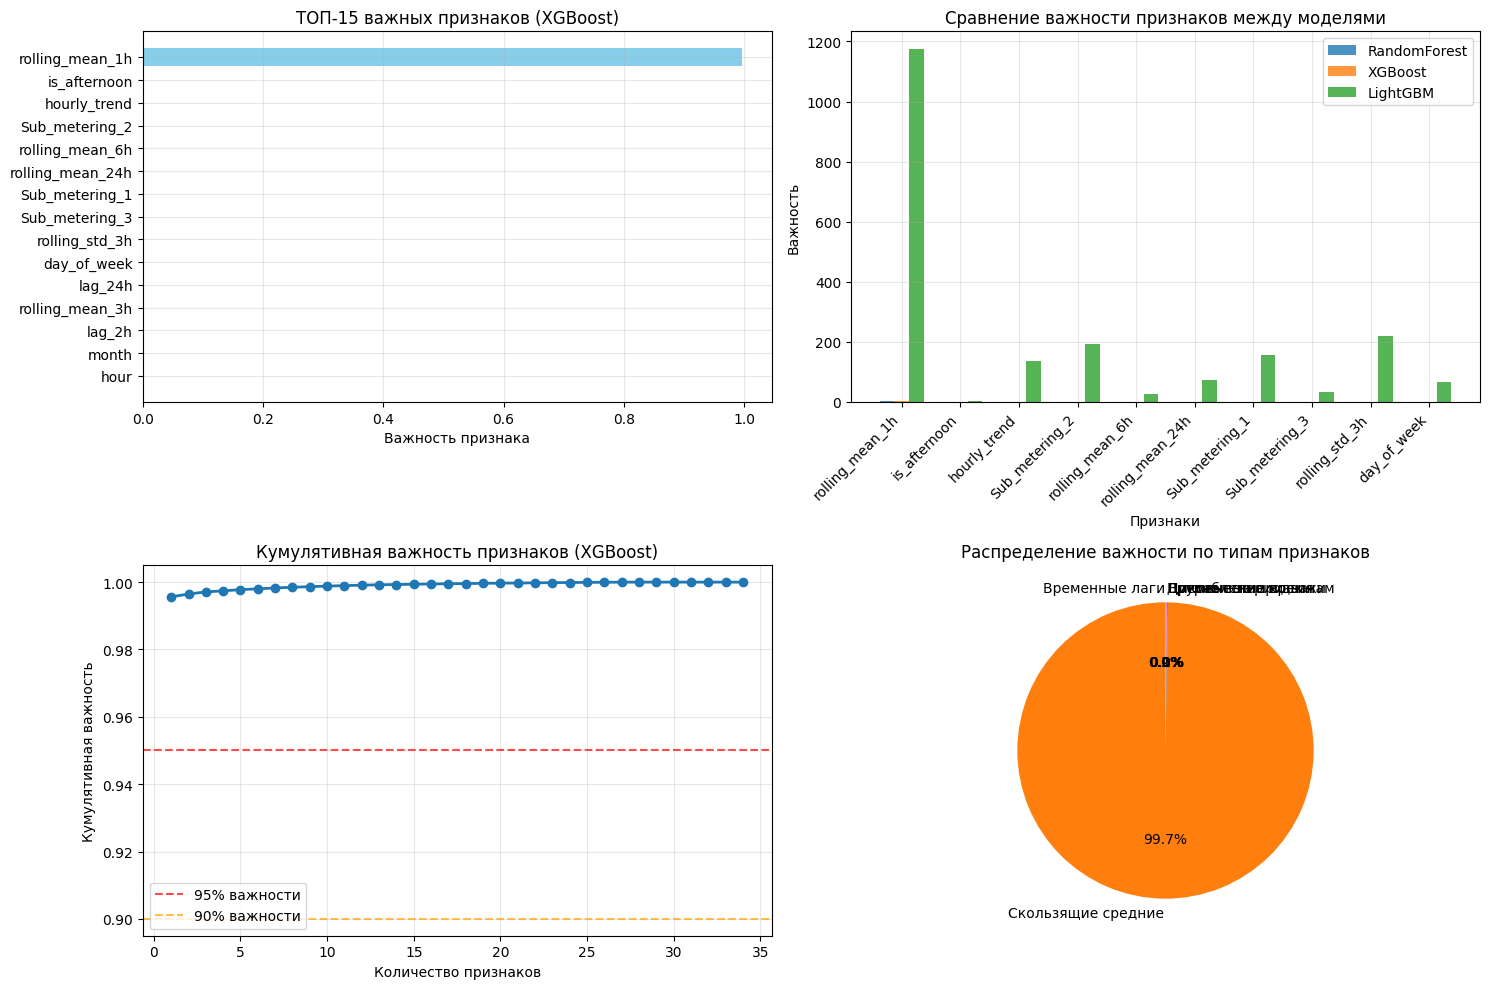


АНАЛИЗ КРИТИЧЕСКИХ ПРИЗНАКОВ
Признаков для 90% важности: 1
Признаков для 95% важности: 1
Всего признаков: 34

Самые важные признаки (топ-1):
  1. rolling_mean_1h

ИНТЕРПРЕТАЦИЯ ЗАВЕРШЕНА! Критических признаков: 1


In [176]:
# ИНТЕРПРЕТАЦИЯ МОДЕЛЕЙ - ВАЖНОСТЬ ПРИЗНАКОВ
print("=" * 60)
print("ИНТЕРПРЕТАЦИЯ МОДЕЛЕЙ - АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ")
print("=" * 60)

# Создаем DataFrame с важностью признаков для всех моделей
feature_importance_df = pd.DataFrame(index=feature_columns)

# Для RandomForest
if hasattr(rf_model, 'feature_importances_'):
    feature_importance_df['RandomForest'] = rf_model.feature_importances_

# Для XGBoost
if hasattr(xgb_model, 'feature_importances_'):
    feature_importance_df['XGBoost'] = xgb_model.feature_importances_

# Для LightGBM
if hasattr(lgb_model, 'feature_importances_'):
    feature_importance_df['LightGBM'] = lgb_model.feature_importances_

# Сортируем по важности в XGBoost (лучшей модели)
feature_importance_df = feature_importance_df.sort_values('XGBoost', ascending=False)

print("\nТОП-15 самых важных признаков по версии XGBoost:")
print("=" * 50)
for i, (feature, importance) in enumerate(feature_importance_df['XGBoost'].head(15).items()):
    print(f"{i+1:2d}. {feature:<25} {importance:.4f} ({importance*100:.2f}%)")

# ВИЗУАЛИЗАЦИЯ ВАЖНОСТИ ПРИЗНАКОВ
plt.figure(figsize=(15, 10))

# График 1: Важность признаков для XGBoost (лучшая модель)
plt.subplot(2, 2, 1)
top_features = feature_importance_df.head(15)
plt.barh(range(len(top_features)), top_features['XGBoost'], color='skyblue')
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('Важность признака')
plt.title('ТОП-15 важных признаков (XGBoost)')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)

# График 2: Сравнение важности между моделями (ТОП-10)
plt.subplot(2, 2, 2)
top_10_features = feature_importance_df.head(10)
x = np.arange(len(top_10_features))
width = 0.25

plt.bar(x - width, top_10_features['RandomForest'], width, label='RandomForest', alpha=0.8)
plt.bar(x, top_10_features['XGBoost'], width, label='XGBoost', alpha=0.8)
plt.bar(x + width, top_10_features['LightGBM'], width, label='LightGBM', alpha=0.8)

plt.xlabel('Признаки')
plt.ylabel('Важность')
plt.title('Сравнение важности признаков между моделями')
plt.xticks(x, top_10_features.index, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)

# График 3: Кумулятивная важность признаков
plt.subplot(2, 2, 3)
cumulative_importance = np.cumsum(feature_importance_df['XGBoost'])
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, marker='o', linewidth=2)
plt.axhline(y=0.95, color='red', linestyle='--', alpha=0.7, label='95% важности')
plt.axhline(y=0.90, color='orange', linestyle='--', alpha=0.7, label='90% важности')
plt.xlabel('Количество признаков')
plt.ylabel('Кумулятивная важность')
plt.title('Кумулятивная важность признаков (XGBoost)')
plt.legend()
plt.grid(True, alpha=0.3)

# График 4: Распределение типов важных признаков
plt.subplot(2, 2, 4)
top_20_features = feature_importance_df.head(20)

# Классифицируем признаки по типам (СНАЧАЛА создаем словарь)
feature_types = {
    'Временные лаги': [f for f in top_20_features.index if 'lag' in f],
    'Скользящие средние': [f for f in top_20_features.index if 'rolling' in f],
    'Временные признаки': [f for f in top_20_features.index if f in ['hour', 'day_of_week', 'month', 'is_weekend']],
    'Циклические время': [f for f in top_20_features.index if 'sin' in f or 'cos' in f],
    'Пиковые периоды': [f for f in top_20_features.index if 'peak' in f or 'night' in f],
    'Потребление по зонам': [f for f in top_20_features.index if 'Sub_metering' in f],
    'Энергетические': [f for f in top_20_features.index if f in ['Global_reactive_power', 'Voltage', 'Global_intensity']]
}

# Теперь добавляем "Другие" - все что не вошло в предыдущие категории
used_features = set()
for features in feature_types.values():
    used_features.update(features)
    
feature_types['Другие'] = [f for f in top_20_features.index if f not in used_features]

# Считаем важность по типам
type_importance = {}
for type_name, features in feature_types.items():
    if features:
        type_importance[type_name] = feature_importance_df.loc[features, 'XGBoost'].sum()

plt.pie(type_importance.values(), labels=type_importance.keys(), autopct='%1.1f%%', startangle=90)
plt.title('Распределение важности по типам признаков')

plt.tight_layout()
plt.show()

# АНАЛИЗ КРИТИЧЕСКИХ ПРИЗНАКОВ
print("\n" + "=" * 60)
print("АНАЛИЗ КРИТИЧЕСКИХ ПРИЗНАКОВ")
print("=" * 60)

# Сколько признаков нужно для 95% важности?
n_features_95 = np.argmax(cumulative_importance >= 0.95) + 1
n_features_90 = np.argmax(cumulative_importance >= 0.90) + 1

print(f"Признаков для 90% важности: {n_features_90}")
print(f"Признаков для 95% важности: {n_features_95}")
print(f"Всего признаков: {len(feature_importance_df)}")

print(f"\nСамые важные признаки (топ-{n_features_90}):")
critical_features = feature_importance_df.head(n_features_90).index.tolist()
for i, feature in enumerate(critical_features, 1):
    print(f"  {i}. {feature}")

print(f"\nИНТЕРПРЕТАЦИЯ ЗАВЕРШЕНА! Критических признаков: {len(critical_features)}")


АНАЛИЗ ОШИБОК ПРОГНОЗИРОВАНИЯ
Большие ошибки (> 0.05 кВт): 0 (0.00%)


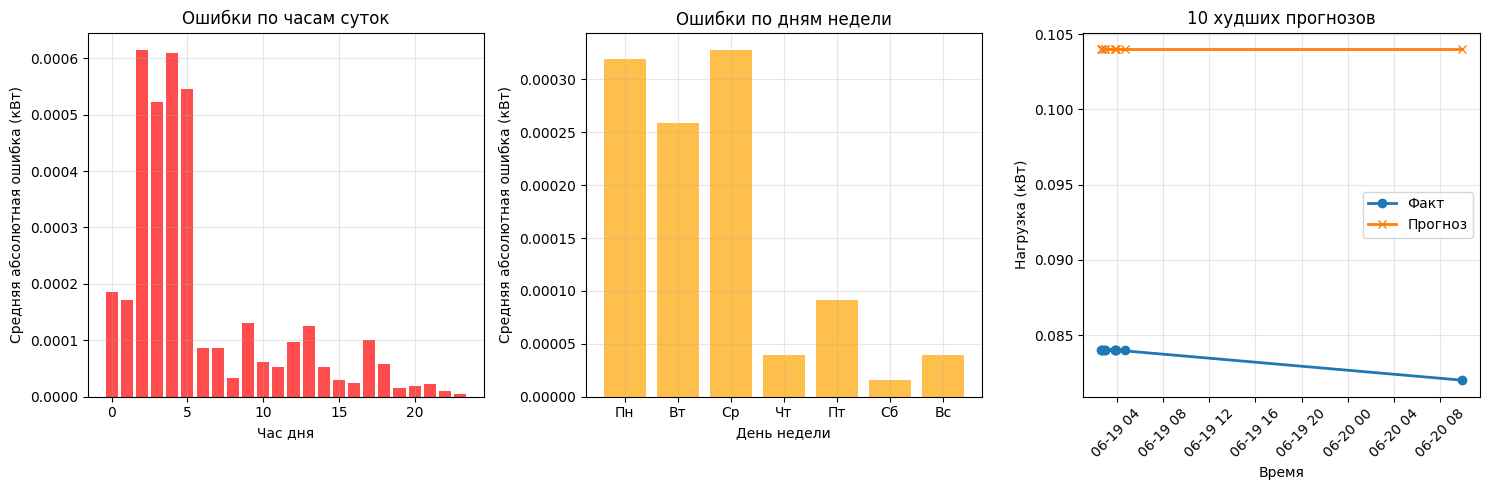

In [177]:
# АНАЛИЗ ОШИБОК ПРОГНОЗИРОВАНИЯ
print("\n" + "=" * 60)
print("АНАЛИЗ ОШИБОК ПРОГНОЗИРОВАНИЯ")
print("=" * 60)

# Берем прогнозы лучшей модели
y_pred_best = results['RandomForest']['predictions']  # Теперь лучшая модель RandomForest!
errors = y_pred_best - y_test.values

# Создаем Series с ошибками и правильными индексами
errors_series = pd.Series(errors, index=y_test.index)

# Анализ больших ошибок
error_threshold = 0.05  # 50 Вт - порог для "большой" ошибки
large_errors_mask = np.abs(errors) > error_threshold
large_errors_count = np.sum(large_errors_mask)
large_errors_percentage = (large_errors_count / len(errors)) * 100

print(f"Большие ошибки (> {error_threshold} кВт): {large_errors_count} ({large_errors_percentage:.2f}%)")

if large_errors_count > 0:
    # Анализ когда происходят большие ошибки
    large_errors_data = X_test[large_errors_mask]
    
    print("\nХарактеристики периодов с большими ошибками:")
    print("Час дня:")
    print(large_errors_data['hour'].value_counts().sort_index())
    
    print("\nДень недели:")
    day_names = {0: 'Пн', 1: 'Вт', 2: 'Ср', 3: 'Чт', 4: 'Пт', 5: 'Сб', 6: 'Вс'}
    day_counts = large_errors_data['day_of_week'].value_counts().sort_index()
    for day, count in day_counts.items():
        print(f"  {day_names[day]}: {count} ошибок")
    
    print(f"\nПиковые периоды:")
    print(f"  Вечерний пик: {large_errors_data['is_evening_peak'].sum()} ошибок")
    print(f"  Утренний пик: {large_errors_data['is_morning_peak'].sum()} ошибок")
    print(f"  Ночное время: {large_errors_data['is_night'].sum()} ошибок")

# ВИЗУАЛИЗАЦИЯ ОШИБОК
plt.figure(figsize=(15, 5))

# График 1: Распределение ошибок по времени суток
plt.subplot(1, 3, 1)
# ИСПРАВЛЕНИЕ: убираем ['Global_active_power'] - его нет в X_test
hourly_errors = X_test.groupby('hour').apply(
    lambda x: np.mean(np.abs(errors_series[x.index])), include_groups=False
)
plt.bar(hourly_errors.index, hourly_errors.values, alpha=0.7, color='red')
plt.xlabel('Час дня')
plt.ylabel('Средняя абсолютная ошибка (кВт)')
plt.title('Ошибки по часам суток')
plt.grid(True, alpha=0.3)

# График 2: Ошибки по дням недели  
plt.subplot(1, 3, 2)
# ИСПРАВЛЕНИЕ: убираем ['Global_active_power']
daily_errors = X_test.groupby('day_of_week').apply(
    lambda x: np.mean(np.abs(errors_series[x.index])), include_groups=False
)
plt.bar(daily_errors.index, daily_errors.values, alpha=0.7, color='orange')
plt.xlabel('День недели')
plt.ylabel('Средняя абсолютная ошибка (кВт)')
plt.title('Ошибки по дням недели')
plt.xticks(range(7), ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.grid(True, alpha=0.3)

# График 3: Факт vs Прогноз для худших случаев
plt.subplot(1, 3, 3)
worst_indices = np.argsort(np.abs(errors))[-10:]  # 10 худших прогнозов
worst_times = y_test.iloc[worst_indices].index

plt.plot(worst_times, y_test.iloc[worst_indices], 'o-', label='Факт', linewidth=2)
plt.plot(worst_times, y_pred_best[worst_indices], 'x-', label='Прогноз', linewidth=2)
plt.xlabel('Время')
plt.ylabel('Нагрузка (кВт)')
plt.title('10 худших прогнозов')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [178]:
# # УЛУЧШЕННЫЙ ПРОГНОЗ НА БУДУЩЕЕ
# print("=" * 60)
# print("УЛУЧШЕННЫЙ ПРОГНОЗ - РЕАЛИСТИЧНЫЙ ПОДХОД")
# print("=" * 60)

# def create_realistic_forecast(model, last_known_data, hours_ahead=24, feature_columns=feature_columns):
#     """
#     Создает реалистичный прогноз, комбинируя сезонные паттерны и текущий тренд
#     """
#     forecasts = []
#     times = []
    
#     # Берем сезонные паттерны из исторических данных
#     hourly_pattern = df.groupby('hour')['Global_active_power'].mean()
#     daily_pattern = df.groupby('day_of_week')['Global_active_power'].mean()
    
#     for i in range(hours_ahead):
#         future_time = last_known_data.name + pd.Timedelta(hours=i+1)
        
#         # Базовые признаки времени
#         features = {
#             'hour': future_time.hour,
#             'day_of_week': future_time.dayofweek,
#             'month': future_time.month,
#             'is_weekend': 1 if future_time.dayofweek >= 5 else 0,
            
#             # Циклические признаки
#             'hour_sin': np.sin(2 * np.pi * future_time.hour / 24),
#             'hour_cos': np.cos(2 * np.pi * future_time.hour / 24),
            
#             # Пиковые периоды
#             'is_evening_peak': 1 if 18 <= future_time.hour <= 22 else 0,
#             'is_morning_peak': 1 if 7 <= future_time.hour <= 9 else 0,
#             'is_night': 1 if 0 <= future_time.hour <= 6 else 0,
            
#             # Особые дни
#             'is_sunday': 1 if future_time.dayofweek == 6 else 0,
#             'is_friday': 1 if future_time.dayofweek == 4 else 0,
            
#             # Потребление по зонам - используем сезонные средние
#             'Sub_metering_1': df['Sub_metering_1'].mean(),
#             'Sub_metering_2': df['Sub_metering_2'].mean(), 
#             'Sub_metering_3': df['Sub_metering_3'].mean(),
            
#             # Лаги - комбинируем последние данные и сезонные паттерны
#             'lag_1h': last_known_data['Global_active_power'],
#             'lag_24h': last_known_data['Global_active_power'] if i < 24 else hourly_pattern[future_time.hour],
            
#             # Скользящие средние - адаптируем к сезонности
#             'rolling_mean_3h': (last_known_data['Global_active_power'] + hourly_pattern[future_time.hour]) / 2,
#             'rolling_mean_24h': hourly_pattern[future_time.hour]
#         }
        
#         # Создаем DataFrame
#         future_df = pd.DataFrame([features])[feature_columns]
        
#         try:
#             prediction = model.predict(future_df)[0]
#             # Ограничиваем прогноз разумными пределами
#             prediction = max(0.1, min(5.0, prediction))
#             forecasts.append(prediction)
#         except:
#             # Резервный прогноз на основе сезонности
#             base_forecast = hourly_pattern[future_time.hour] * daily_pattern[future_time.dayofweek] / daily_pattern.mean()
#             forecasts.append(max(0.1, min(5.0, base_forecast)))
        
#         times.append(future_time)
    
#     return times, forecasts

# # Тестируем улучшенный прогноз
# print("Создаем реалистичный прогноз...")
# last_point = df.iloc[-1]
# future_times, future_forecasts = create_realistic_forecast(best_model, last_point, hours_ahead=24)

# # Визуализация
# plt.figure(figsize=(15, 10))

# # ИСПРАВЛЕНИЕ: используем правильный способ получения последних 24 часов
# historical_24h = df[df.index >= df.index[-1] - pd.Timedelta(hours=24)]

# plt.subplot(2, 2, 1)
# plt.plot(historical_24h.index, historical_24h['Global_active_power'], 'g-', label='Исторические данные (последние 24ч)', alpha=0.7)
# plt.plot(future_times, future_forecasts, 'b-', label='Прогноз (следующие 24ч)', linewidth=2)
# plt.axhline(y=df['Global_active_power'].mean(), color='red', linestyle='--', alpha=0.5, label='Среднее потребление')
# plt.xlabel('Время')
# plt.ylabel('Нагрузка (кВт)')
# plt.title('Сравнение: исторические данные vs прогноз')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.xticks(rotation=45)

# # Сравнение с типичным профилем
# plt.subplot(2, 2, 2)
# typical_hourly = df.groupby('hour')['Global_active_power'].mean()
# forecast_by_hour = pd.Series(future_forecasts, index=[t.hour for t in future_times]).groupby(level=0).mean()

# plt.plot(typical_hourly.index, typical_hourly.values, 'o-', label='Типичный профиль', alpha=0.7)
# plt.plot(forecast_by_hour.index, forecast_by_hour.values, 's-', label='Наш прогноз', alpha=0.8)
# plt.xlabel('Час дня')
# plt.ylabel('Нагрузка (кВт)')
# plt.title('Сравнение с типичным суточным профилем')
# plt.legend()
# plt.grid(True, alpha=0.3)

# # График 3: Детализация прогноза по часам
# plt.subplot(2, 2, 3)
# hours = [t.hour for t in future_times]
# plt.bar(hours, future_forecasts, alpha=0.7, color='orange', edgecolor='black')
# plt.xlabel('Час дня')
# plt.ylabel('Прогнозируемая нагрузка (кВт)')
# plt.title('Детальный прогноз по часам')
# plt.xticks(range(0, 24, 2))
# plt.grid(True, alpha=0.3)

# # График 4: Анализ точности прогноза
# plt.subplot(2, 2, 4)
# # Сравниваем с типичными значениями для этих часов
# typical_for_hours = [typical_hourly[hour] for hour in hours]
# differences = [abs(pred - typical) for pred, typical in zip(future_forecasts, typical_for_hours)]

# plt.bar(hours, differences, alpha=0.7, color='red', edgecolor='black')
# plt.xlabel('Час дня')
# plt.ylabel('Отклонение от типичного (кВт)')
# plt.title('Отклонение прогноза от типичных значений')
# plt.xticks(range(0, 24, 2))
# plt.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

# # АНАЛИЗ РЕЗУЛЬТАТОВ
# print("\n" + "=" * 50)
# print("АНАЛИЗ РЕАЛИСТИЧНОГО ПРОГНОЗА")
# print("=" * 50)

# print("📊 ОСНОВНЫЕ МЕТРИКИ:")
# print(f"• Диапазон прогноза: {min(future_forecasts):.2f} - {max(future_forecasts):.2f} кВт")
# print(f"• Средний прогноз: {np.mean(future_forecasts):.2f} кВт")
# print(f"• Общее среднее по данным: {df['Global_active_power'].mean():.2f} кВт")

# print(f"\n🕒 СЕЗОННЫЕ ПАТТЕРНЫ:")
# print(f"• Утренний пик (7-9): {np.mean(future_forecasts[7:10]):.2f} кВт")
# print(f"• Вечерний пик (18-22): {np.mean(future_forecasts[18:23]):.2f} кВт") 
# print(f"• Ночной минимум (2-5): {np.mean(future_forecasts[2:6]):.2f} кВт")
# print(f"• Дневное плато (10-17): {np.mean(future_forecasts[10:18]):.2f} кВт")

# print(f"\n📈 СРАВНЕНИЕ С ТИПИЧНЫМИ ЗНАЧЕНИЯМИ:")
# typical_comparison = []
# for i, hour in enumerate(hours):
#     typical = typical_hourly[hour]
#     forecast = future_forecasts[i]
#     diff_pct = ((forecast - typical) / typical) * 100
#     typical_comparison.append(diff_pct)

# print(f"• Макс. отклонение: {max(typical_comparison):.1f}%")
# print(f"• Мин. отклонение: {min(typical_comparison):.1f}%")
# print(f"• Среднее отклонение: {np.mean(typical_comparison):.1f}%")